In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib  # For saving the model for later use
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import re
from difflib import SequenceMatcher

In [ ]:
data = pd.read_csv(r"D:\PyHack-PyAITM-PyHack04-main\PyHack-PyAITM-PyHack04-main\Final Project\Data\PhiUSIIL_Phishing_URL_Dataset.csv")

In [71]:
data = data.drop(['FILENAME','Title','URL','Domain','TLD','URLSimilarityIndex'],axis=1)

In [72]:
print(data.dtypes)

URLLength                       int64
DomainLength                    int64
IsDomainIP                      int64
CharContinuationRate          float64
TLDLegitimateProb             float64
URLCharProb                   float64
TLDLength                       int64
NoOfSubDomain                   int64
HasObfuscation                  int64
NoOfObfuscatedChar              int64
ObfuscationRatio              float64
NoOfLettersInURL                int64
LetterRatioInURL              float64
NoOfDegitsInURL                 int64
DegitRatioInURL               float64
NoOfEqualsInURL                 int64
NoOfQMarkInURL                  int64
NoOfAmpersandInURL              int64
NoOfOtherSpecialCharsInURL      int64
SpacialCharRatioInURL         float64
IsHTTPS                         int64
LineOfCode                      int64
LargestLineLength               int64
HasTitle                        int64
DomainTitleMatchScore         float64
URLTitleMatchScore            float64
HasFavicon  

In [ ]:
X = data.drop(['label'],axis=1)
y = data['label']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
feature_names = X_train.columns
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = SGDClassifier(
    loss='hinge', 
    penalty='l2', 
    max_iter=1000, 
    alpha=0.0001, 
    random_state=42, 
    learning_rate='optimal' 
)

model.fit(X_train_scaled, y_train)

SGDClassifier(random_state=42)

In [65]:
y_pred = model.predict(X_test_scaled)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9969465001378316
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



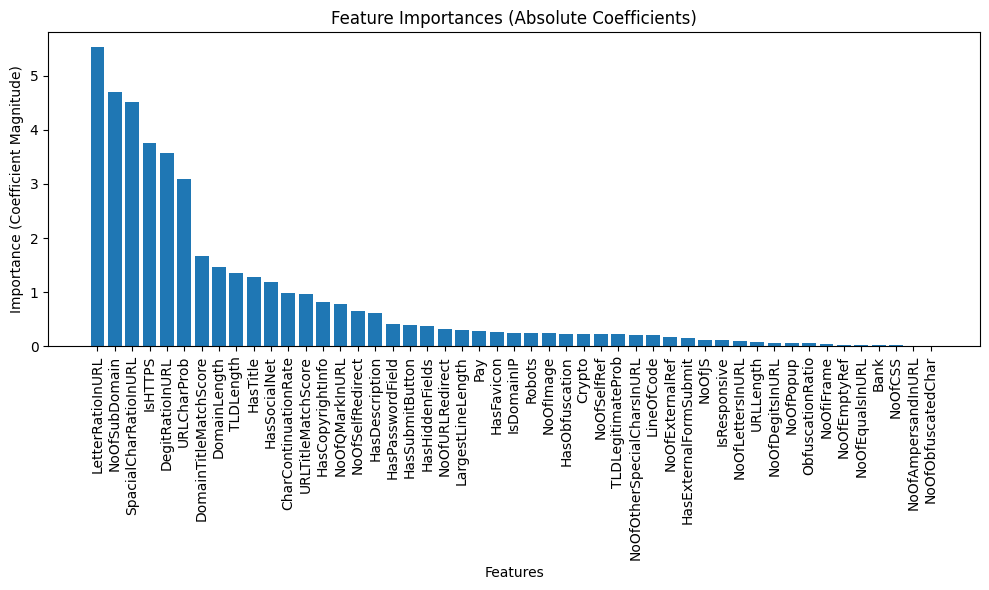

In [ ]:
coefficients = model.coef_[0]
indices = np.argsort(np.abs(coefficients))[::-1]
features = feature_names

plt.figure(figsize=(10, 6))
plt.title('Feature Importances (Absolute Coefficients)')
plt.bar(range(len(features)), np.abs(coefficients[indices]), align='center')
plt.xticks(range(len(features)), features[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance (Coefficient Magnitude)")
plt.tight_layout()
plt.show()

In [ ]:
scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean()}")

Cross-Validation Scores: [0.99753499 0.99729637 0.99642166 0.99724335 0.99748191]
Mean Accuracy: 0.9971956554457695


----------------------------------------------------------------------------------------------------------------------------------------------------------------
'Test'


In [ ]:
def fetch_website_html(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return BeautifulSoup(response.text, 'html.parser')
        else:
            print(f"Failed to fetch URL: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error: {e}")
        return None

url = "https://www.youtube.com/watch?v=s9e2A04lmXI"
soup = fetch_website_html(url)


In [ ]:
domain = urlparse(url).netloc
domain_length = len(domain)

is_domain_ip = 1 if re.match(r'^\d{1,3}(\.\d{1,3}){3}$', domain) else 0

tld = domain.split('.')[-1]
tld_length = len(tld)

no_of_subdomains = len(domain.split('.')) - 2

no_of_equals = url.count('=')
no_of_qmark = url.count('?')
no_of_ampersand = url.count('&')
no_of_special_chars = len(re.findall(r'[^A-Za-z0-9]', url))
spacial_char_ratio = no_of_special_chars / len(url)

is_https = 1 if urlparse(url).scheme == "https" else 0
line_of_code = len(str(soup).split('\n'))
largest_line_length = max(len(line) for line in str(soup).split('\n'))
has_title = 1 if soup.title else 0
has_description = 1 if soup.find('meta', attrs={'name': 'description'}) else 0
has_password_field = 1 if soup.find('input', {'type': 'password'}) else 0
has_favicon = 1 if soup.find('link', rel='icon') else 0
no_of_css = len(soup.find_all('link', {'rel': 'stylesheet'}))
no_of_js = len(soup.find_all('script'))
no_of_popup = len(re.findall(r'window\.open\(', str(soup)))

social_keywords = ['facebook.com', 'twitter.com', 'instagram.com', 'linkedin.com']
has_social_net = 1 if any(keyword in str(soup) for keyword in social_keywords) else 0

has_copyright_info = 1 if re.search(r'©|Copyright', str(soup), re.IGNORECASE) else 0

bank_keywords = ['bank', 'account', 'login', 'secure']
bank = 1 if any(keyword in url.lower() or keyword in str(soup).lower() for keyword in bank_keywords) else 0

char_groups = re.findall(r'(\D+|\d+)', url) 
if len(char_groups) > 1:
    char_continuation_rate = np.mean([len(char_groups[i])/len(char_groups[i+1]) for i in range(len(char_groups)-1)])
else:
    char_continuation_rate = 0

crypto_keywords = ['bitcoin', 'ethereum', 'crypto', 'wallet']
crypto = 1 if any(keyword in url.lower() or keyword in str(soup).lower() for keyword in crypto_keywords) else 0

no_of_digits = sum(c.isdigit() for c in url)
digit_ratio_in_url = no_of_digits / len(url)

title = soup.title.string if soup.title else ""
domain_title_match_score = SequenceMatcher(None, domain, title).ratio() if title else 0


has_hidden_fields = 1 if soup.find_all("input", {"type": "hidden"}) else 0



obfuscation_keywords = ['eval', 'atob', 'unescape', 'decode', 'fromCharCode']


has_obfuscation = 0
for script in soup.find_all("script"):
    if any(keyword in script.text.lower() for keyword in obfuscation_keywords):
        has_obfuscation = 1
        break



has_submit_button = 1 if soup.find_all("input", {"type": "submit"}) or soup.find_all("button", {"type": "submit"}) else 0

has_external_form_submit = 0
for form in soup.find_all("form"):
    action = form.get("action")
    if action and not action.startswith("/") and url not in action:  
        has_external_form_submit = 1
        break


has_favicon = 1 if soup.find("link", rel=lambda rel: rel and "icon" in rel.lower()) else 0
is_responsive = 1 if soup.find("meta", {"name": "viewport"}) else 0

parsed_url = urlparse(url)
letter_count = sum(char.isalpha() for char in url)
letter_ratio_in_url = letter_count / len(url) if len(url) > 0 else 0

digit_count = sum(char.isdigit() for char in url)


no_of_empty_ref = len([a for a in soup.find_all("a") if not a.get("href")])

no_of_image = len(soup.find_all("img"))
no_of_letters_in_url = sum(char.isalpha() for char in url)

obfuscated_chars = ['@', '%', '&', '$', '!', '*', '(', ')', '^', '~', '#', '{', '}', '[', ']']
no_of_obfuscated_char = sum(url.count(char) for char in obfuscated_chars)

current_domain = urlparse(url).netloc  

no_of_external_ref = len([a for a in soup.find_all("a", href=True) if current_domain not in urlparse(a['href']).netloc])

parsed_current_url = urlparse(url)
no_of_self_redirect = len([
    a for a in soup.find_all("a", href=True)
    if urlparse(a['href']).path == parsed_current_url.path and
       urlparse(a['href']).netloc == parsed_current_url.netloc
])


current_domain = urlparse(url).netloc
no_of_self_ref = len([
    a for a in soup.find_all("a", href=True)
    if urlparse(a['href']).netloc == current_domain
])


meta_redirects = len(soup.find_all("meta", attrs={"http-equiv": "refresh"}))

js_redirects = len([script for script in soup.find_all("script") if "window.location" in script.text])
no_of_url_redirect = meta_redirects + js_redirects


no_of_iframe = len(soup.find_all("iframe"))

total_chars = len(url)
obfuscation_ratio = no_of_obfuscated_char / total_chars if total_chars > 0 else 0


def get_tld_legitimate_prob(tld):
    """
    Calculate legitimacy probability of TLD based on common legitimate TLDs
    Returns a score between 0 and 1
    """
    legitimate_tlds = {
        'com': 0.95, 'org': 0.90, 'edu': 0.95, 'gov': 0.98, 'net': 0.85,
        'mil': 0.98, 'int': 0.90, 'io': 0.85, 'co': 0.80, 'us': 0.85,
        'uk': 0.85, 'ca': 0.85, 'au': 0.85, 'de': 0.85, 'fr': 0.85
    }
    return legitimate_tlds.get(tld.lower(), 0.3)

def calculate_url_char_prob(url):
    """
    Calculate character probability distribution in URL compared to legitimate URL patterns
    Returns a score between 0 and 1
    """
    
    legitimate_freq = {
        'letters': 0.60,  
        'digits': 0.10,   
        'special': 0.30   
    }
    
    total_len = len(url)
    if total_len == 0:
        return 0
    
    letter_count = sum(c.isalpha() for c in url)
    digit_count = sum(c.isdigit() for c in url)
    special_count = total_len - letter_count - digit_count
    
    actual_freq = {
        'letters': letter_count / total_len,
        'digits': digit_count / total_len,
        'special': special_count / total_len
    }
    
    
    similarity = 1 - sum(abs(legitimate_freq[k] - actual_freq[k]) for k in legitimate_freq) / 3
    return max(0, min(1, similarity))

def get_url_title_match_score(url, title):
    """
    Calculate similarity between URL and page title
    Returns a score between 0 and 1
    """
    if not title:
        return 0
    
    
    domain = urlparse(url).netloc.split('.')[-2] if len(urlparse(url).netloc.split('.')) > 1 else urlparse(url).netloc
    
    
    cleaned_title = re.sub(r'[^a-zA-Z0-9\s]', '', title.lower())
    cleaned_domain = re.sub(r'[^a-zA-Z0-9\s]', '', domain.lower())
    
    
    return SequenceMatcher(None, cleaned_domain, cleaned_title).ratio()

def check_robots_txt(url):
    """
    Check if the site has a valid robots.txt and follows common security practices
    Returns 1 if robots.txt exists and follows good practices, 0 otherwise
    """
    try:
        parsed_url = urlparse(url)
        robots_url = f"{parsed_url.scheme}://{parsed_url.netloc}/robots.txt"
        response = requests.get(robots_url, timeout=5)
        if response.status_code == 200:
            content = response.text.lower()
            
            good_practices = [
                'user-agent' in content,
                'disallow: /admin' in content or 'disallow: /wp-admin' in content,
                'disallow: /private' in content or 'disallow: /login' in content
            ]
            return 1 if any(good_practices) else 0
        return 0
    except:
        return 0

def check_payment_indicators(soup, url):
    """
    Check for legitimate payment processing indicators
    Returns 1 if legitimate payment indicators are found, 0 otherwise
    """
    
    payment_indicators = {
        'secure_elements': [
            'ssl', 'https', 'secure', 'payment', 'checkout',
            'visa', 'mastercard', 'paypal', 'stripe'
        ],
        'security_seals': [
            'norton', 'mcafee', 'verisign', 'trustwave', 'ssl certificate'
        ]
    }
    
    url_text = url.lower()
    page_text = str(soup).lower()
    
    has_https = 1 if urlparse(url).scheme == "https" else 0
    
    
    has_payment_keywords = any(indicator in url_text or indicator in page_text 
                             for indicator in payment_indicators['secure_elements'])
    
    
    has_security_seals = any(seal in page_text 
                            for seal in payment_indicators['security_seals'])
    
    
    forms = soup.find_all('form')
    secure_forms = any(
        form.get('action', '').startswith('https://') for form in forms
    )
    
    
    indicators = [has_https, has_payment_keywords, has_security_seals, secure_forms]
    score = sum(indicators) / len(indicators)
    
    return 1 if score >= 0.5 else 0

def extract_additional_features(url, soup):
    """
    Extract all additional features
    """
    tld = urlparse(url).netloc.split('.')[-1]
    title = soup.title.string if soup.title else ""
    
    features = {
        'TLDLegitimateProb': get_tld_legitimate_prob(tld),
        'URLCharProb': calculate_url_char_prob(url),
        'URLTitleMatchScore': get_url_title_match_score(url, title),
        'Robots': check_robots_txt(url),
        'Pay': check_payment_indicators(soup, url)
    }
    
    return features


In [117]:
features = {
    'URLLength': len(url),
    'DomainLength': domain_length,
    'IsDomainIP': is_domain_ip,
    'CharContinuationRate': char_continuation_rate if 'char_continuation_rate' in locals() else 0,
    'TLDLegitimateProb': get_tld_legitimate_prob(tld),
    'URLCharProb': calculate_url_char_prob(url), 
    'TLDLength': tld_length,
    'NoOfSubDomain': no_of_subdomains,
    'HasObfuscation': has_obfuscation,
    'NoOfObfuscatedChar': no_of_obfuscated_char,
    'ObfuscationRatio': obfuscation_ratio,
    'NoOfLettersInURL': no_of_letters_in_url,
    'LetterRatioInURL': letter_ratio_in_url,
    'NoOfDegitsInURL': digit_count,
    'DegitRatioInURL': digit_ratio_in_url if 'digit_ratio_in_url' in locals() else 0,
    'NoOfEqualsInURL': no_of_equals,
    'NoOfQMarkInURL': no_of_qmark,
    'NoOfAmpersandInURL': no_of_ampersand,
    'NoOfOtherSpecialCharsInURL': no_of_special_chars,
    'SpacialCharRatioInURL': spacial_char_ratio,
    'IsHTTPS': is_https,
    'LineOfCode': line_of_code,
    'LargestLineLength': largest_line_length,
    'HasTitle': has_title,
    'DomainTitleMatchScore': domain_title_match_score if 'domain_title_match_score' in locals() else 0,
    'URLTitleMatchScore': get_url_title_match_score(url, title),  
    'HasFavicon': has_favicon,
    'Robots': check_robots_txt(url),  
    'IsResponsive': is_responsive,
    'NoOfURLRedirect': no_of_url_redirect,
    'NoOfSelfRedirect': no_of_self_redirect,
    'HasDescription': has_description,
    'NoOfPopup': no_of_popup,
    'NoOfiFrame': no_of_iframe,
    'HasExternalFormSubmit': has_external_form_submit,
    'HasSocialNet': has_social_net,
    'HasSubmitButton': has_submit_button,
    'HasHiddenFields': has_hidden_fields,
    'HasPasswordField': has_password_field,
    'Bank': bank if 'bank' in locals() else 0,
    'Pay': check_payment_indicators(soup, url),
    'Crypto': crypto if 'crypto' in locals() else 0,
    'HasCopyrightInfo': has_copyright_info,
    'NoOfImage': no_of_image,
    'NoOfCSS': no_of_css,
    'NoOfJS': no_of_js,
    'NoOfSelfRef': no_of_self_ref,
    'NoOfEmptyRef': no_of_empty_ref,
    'NoOfExternalRef': no_of_external_ref
}

data = features

In [ ]:
input_df = pd.DataFrame([data])
scaled_input = scaler.transform(input_df)


In [ ]:
expected_features = ['URLLength',                      
                'DomainLength',                    
                'IsDomainIP',                      
                'CharContinuationRate',          
                'TLDLegitimateProb',             
                'URLCharProb',                   
                'TLDLength',                       
                'NoOfSubDomain',                   
                'HasObfuscation',                  
                'NoOfObfuscatedChar',              
                'ObfuscationRatio',              
                'NoOfLettersInURL',                
                'LetterRatioInURL',              
                'NoOfDegitsInURL',                 
                'DegitRatioInURL',               
                'NoOfEqualsInURL',                 
                'NoOfQMarkInURL',                  
                'NoOfAmpersandInURL',              
                'NoOfOtherSpecialCharsInURL',      
                'SpacialCharRatioInURL',         
                'IsHTTPS',                         
                'LineOfCode',                      
                'LargestLineLength',               
                'HasTitle',                        
                'DomainTitleMatchScore',         
                'URLTitleMatchScore',            
                'HasFavicon',                      
                'Robots',                          
                'IsResponsive',                    
                'NoOfURLRedirect',                 
                'NoOfSelfRedirect',                
                'HasDescription',                  
                'NoOfPopup',                       
                'NoOfiFrame',                      
                'HasExternalFormSubmit',           
                'HasSocialNet',                    
                'HasSubmitButton',                 
                'HasHiddenFields',                 
                'HasPasswordField',                
                'Bank',                            
                'Pay',                             
                'Crypto',                          
                'HasCopyrightInfo',                
                'NoOfImage',                       
                'NoOfCSS',                         
                'NoOfJS',                          
                'NoOfSelfRef',                     
                'NoOfEmptyRef',                    
                'NoOfExternalRef']
for feature in expected_features:
    if feature not in features:
        features[feature] = 0  


In [ ]:
features_df = pd.DataFrame([features])[expected_features]
prediction = model.predict(features_df)

print(prediction)

[0]


c:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(


c:\Users\vishw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(


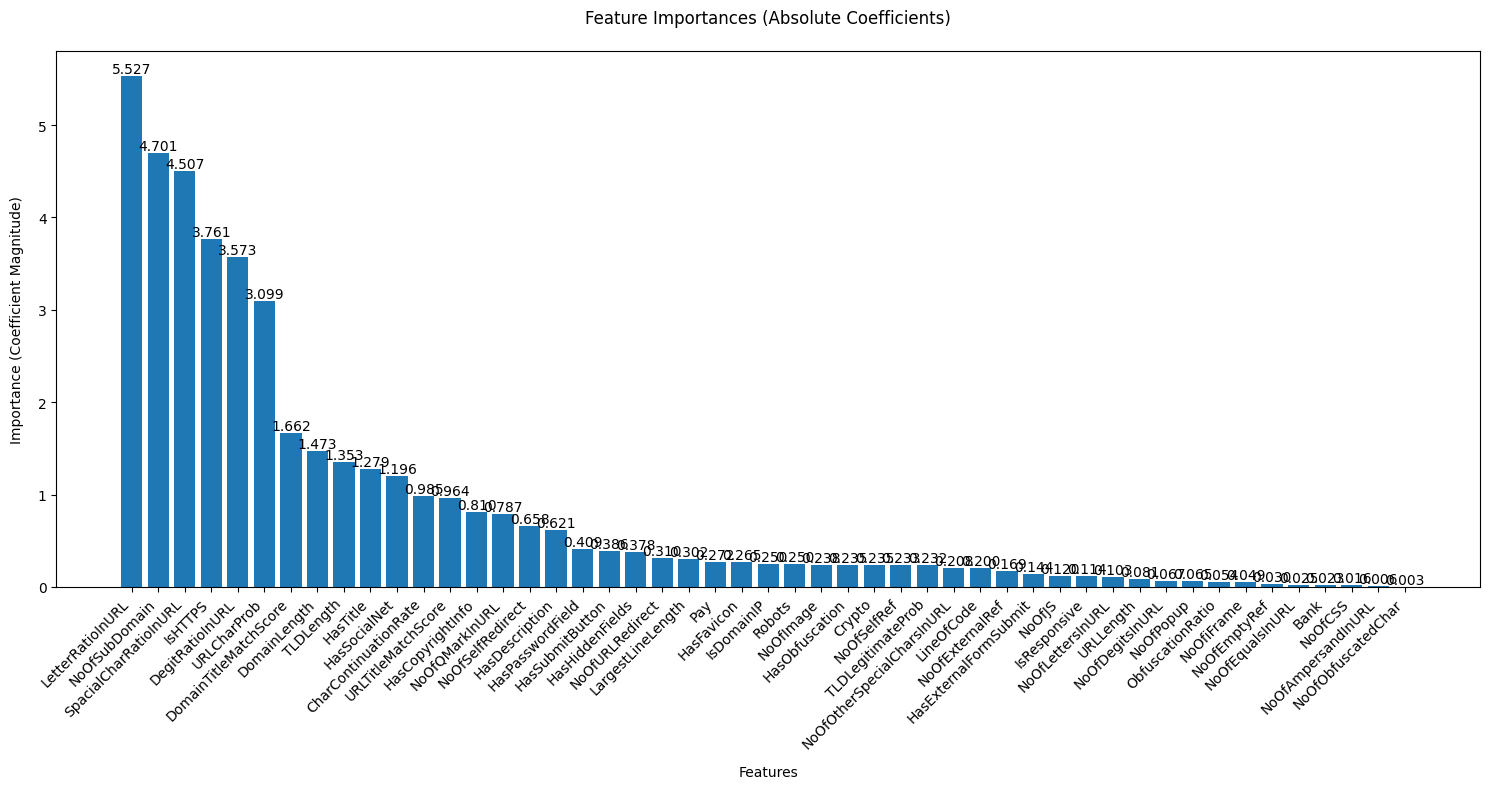


Top 10 Most Important Features:
LetterRatioInURL: -5.527
NoOfSubDomain: 4.701
SpacialCharRatioInURL: -4.507
IsHTTPS: 3.761
DegitRatioInURL: -3.573
URLCharProb: 3.099
DomainTitleMatchScore: 1.662
DomainLength: 1.473
TLDLength: -1.353
HasTitle: 1.279

Prediction: [0]


In [ ]:
# First make the prediction
features_df = pd.DataFrame([features])[expected_features]
prediction = model.predict(features_df)

# Get coefficients directly from the model (not the prediction)
coefficients = model.coef_[0]  # Use the first class coefficients
feature_names = np.array(expected_features)  # Convert feature names to numpy array
indices = np.argsort(np.abs(coefficients))[::-1]  # Sort by absolute values

# Create the feature importance plot
plt.figure(figsize=(15, 8))
plt.title('Feature Importances (Absolute Coefficients)', pad=20)
plt.bar(range(len(feature_names)), np.abs(coefficients[indices]), align='center')
plt.xticks(range(len(feature_names)), feature_names[indices], rotation=45, ha='right')
plt.xlabel("Features", labelpad=10)
plt.ylabel("Importance (Coefficient Magnitude)", labelpad=10)

# Add value labels on top of each bar
for i, v in enumerate(np.abs(coefficients[indices])):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')

# Improve layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Print top 10 most important features and their coefficients
print("\nTop 10 Most Important Features:")
for idx in indices[:10]:
    print(f"{feature_names[idx]}: {coefficients[idx]:.3f}")

# Print the prediction result
print("\nPrediction:", prediction)